Author: Wenxin Yang

#  Preparation

##  import packages

In [1]:
import geopandas as gpd
import json
import pandas as pd
import requests
from io import StringIO
from shapely.geometry import Point
import matplotlib.pyplot as plt
from census_area import Census

##  load data
###  car crash data

In [2]:
url = 'https://data.boston.gov/dataset/7b29c1b2-7ec2-4023-8292-c24f5d8f0905/resource/e4bfe397-6bfc-49c5-9367-c879fac7401d/download/crash_april_2019.csv.csv'

r = requests.get(url)
df = pd.read_csv(StringIO(r.text))

In [3]:
len(df)

17912

In [3]:
df['coord'] = list(zip(df.long, df.lat))

df['coord'] = df['coord'].apply(Point)

crash = gpd.GeoDataFrame(df, geometry = 'coord')

crash.crs = ({'init':'epsg:26986'})

In [4]:
my_api_key = '51a775979b7e8be111c120dca85b7ce106eb26d2' # get api key for census data api
api_key = my_api_key
c = Census(key=api_key)

In [5]:
ma_code = 25
boston_code = '07000'

#from https://api.census.gov/data/2017/acs/acs5/variables.html
#B19013_001E is the code for median household income
variables = ('NAME', 'B19013_001E') 
result = c.acs5.state_place(variables, ma_code, 
                            boston_code, year=2017)

In [6]:
inc_tracts = c.acs5.state_place_tract(variables, ma_code, 
                                      boston_code, 
                                      return_geometry=True)
crs = {'init':'epsg:26986'}
inc_df = gpd.GeoDataFrame.from_features(inc_tracts, crs=crs)
len(inc_df)

185

In [7]:
min(inc_df['B19013_001E'])

-666666666.0

In [7]:
inc_df = inc_df.loc[inc_df['B19013_001E']>0]
len(inc_df)

174

# Analyzing Data
## trim the datasets

In [9]:
joined = gpd.sjoin(crash, inc_df, op='within', how='left')

### prepare the data frame (df1) for the regressions and figure 1

In [10]:
by_tract = joined.groupby('tract').size().reset_index()
by_tract.columns = ['tract','count']
by_tract = pd.merge(inc_df,by_tract,on ='tract')

In [11]:
simp = by_tract[['B19013_001E','tract','count','geometry']]
simp.columns = ['med_inc','tract','count','geometry']
simp['count_per_area'] = simp['count']/(simp.geometry.area)
df1 = simp.loc[simp['med_inc']>0]

C:\Users\ywx12\Anaconda3\envs\musa\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### prepare the data frame (df2) for figure 2

In [12]:
by_crash = joined.groupby(['lat','long','B19013_001E','tract']).size().reset_index()
by_crash.columns = ['lat','long','med_inc','tract','count_crash']
by_crash['coord'] = list(zip(by_crash.long,by_crash.lat))
by_crash['coord'] = by_crash['coord'].apply(Point)
gpd_by_crash = gpd.GeoDataFrame(by_crash, geometry = 'coord')
df2 = gpd_by_crash[['med_inc','tract','count_crash','coord']]

## linear regressions

In [13]:
import statsmodels.api as sm

### regression 1: regressing median household income on total number of crashes by census tract

In [14]:
# to include intercept in the regression, it is necessary to
# manually create a column of '1'
df11 = df1
df11['cons'] = 1

In [15]:
reg1 = sm.OLS(endog=df11['count'], exog=df11[['med_inc','cons']], missing='drop')
result1 = reg1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.805
Date:                Wed, 10 Apr 2019   Prob (F-statistic):              0.181
Time:                        22:03:41   Log-Likelihood:                -995.07
No. Observations:                 171   AIC:                             1994.
Df Residuals:                     169   BIC:                             2000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
med_inc       -0.0002      0.000     -1.343      0.1

### regression 2: regressing median household income on density of crashes by census tract

In [16]:
reg2 = sm.OLS(endog = df11['count_per_area'], exog = df11[['med_inc','cons']], missing = 'drop')
result2 = reg2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:         count_per_area   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     12.73
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           0.000469
Time:                        22:03:41   Log-Likelihood:                -2654.3
No. Observations:                 171   AIC:                             5313.
Df Residuals:                     169   BIC:                             5319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
med_inc      -10.4808      2.938     -3.567      0.0

## export the data to shapefile

In [17]:
df1.to_file('./df1', driver='ESRI Shapefile', schema=None)
df2.to_file('./df2', driver='ESRI Shapefile', schema=None)

# Some visualizations

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

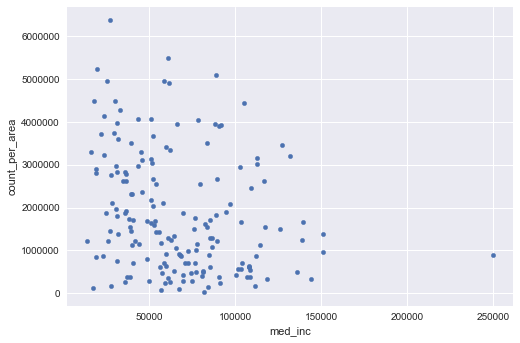

In [19]:
dff1 = df1[['med_inc','count','count_per_area']]
plt.style.use('seaborn')

dff1.plot(x='med_inc', y='count_per_area', kind='scatter')
plt.show()

In [20]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [21]:
data_df1  = alt.InlineData(values=df1.to_crs(epsg=4326).to_json(),
                       format=alt.DataFormat(property='features',type='json'))

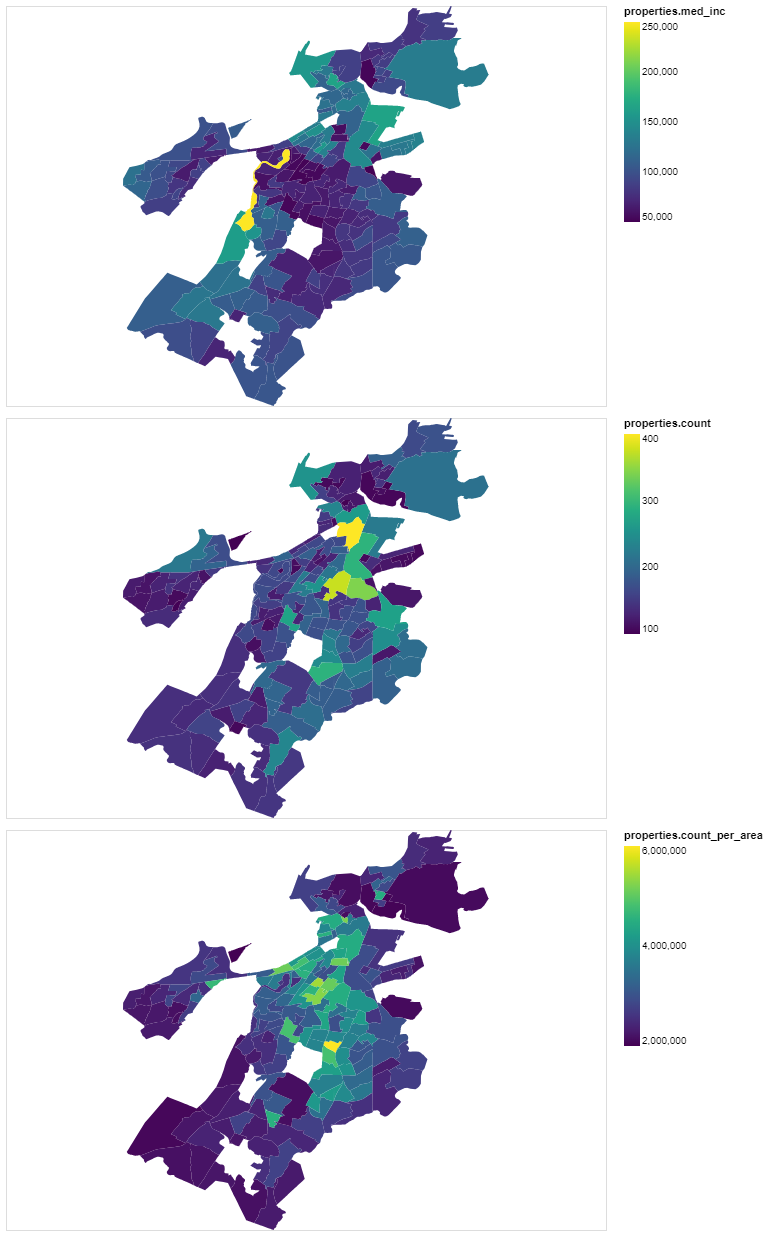

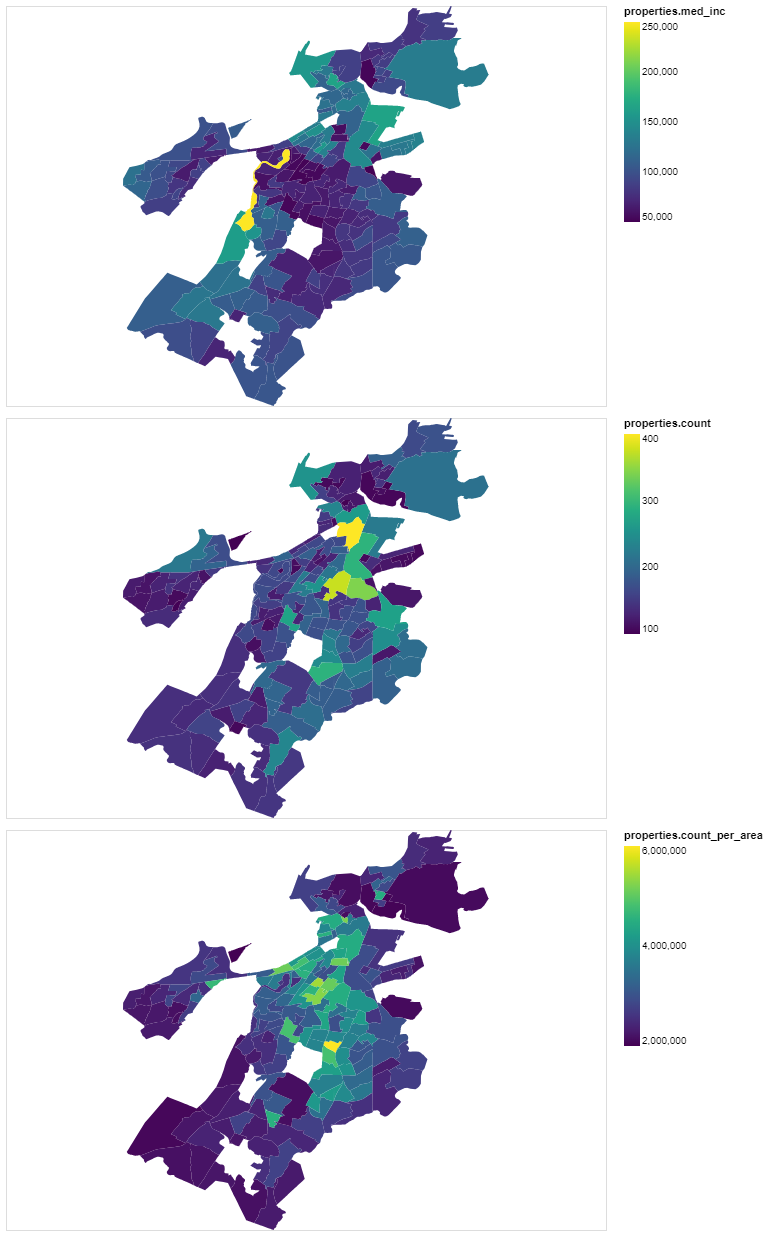

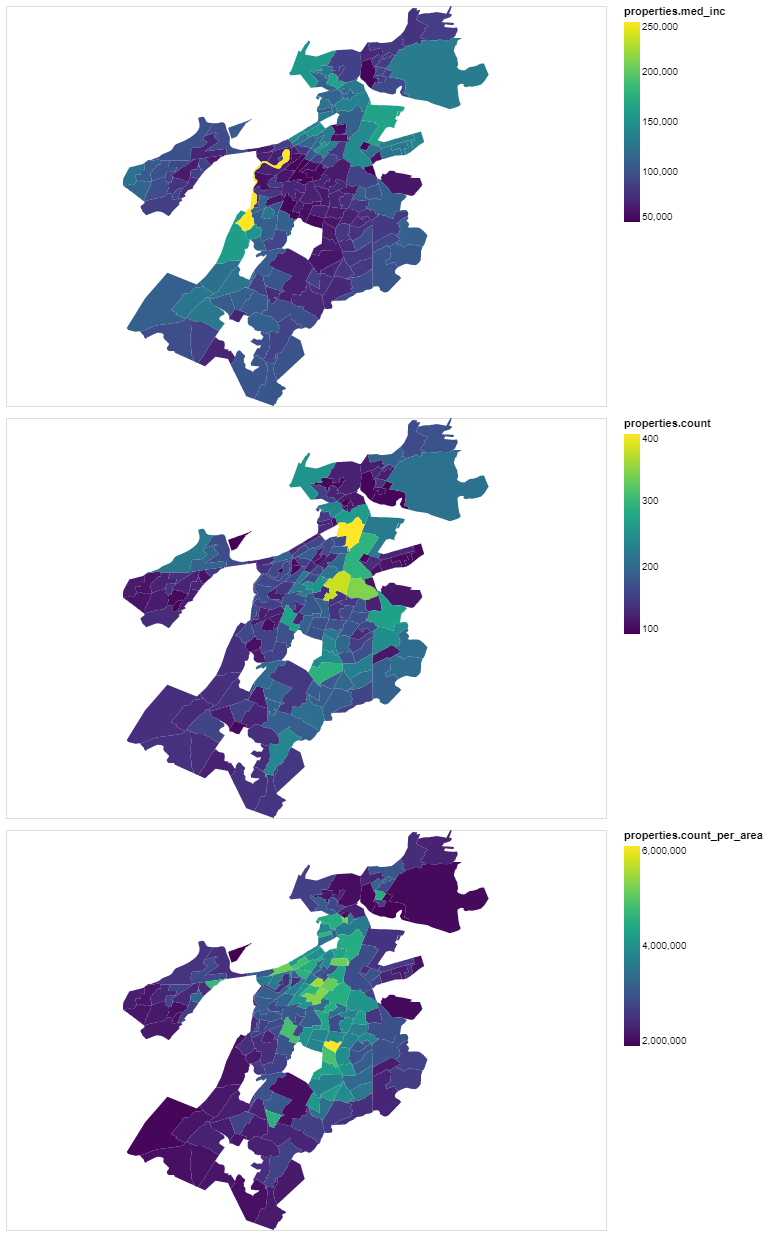

In [22]:
variable_list = ['properties.med_inc', 'properties.count', 'properties.count_per_area']

alt.Chart(data_df1).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(data_df1, 'id', variable_list)
).properties(
    width=600,
    height=400
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)
